<a href="https://colab.research.google.com/github/nati-curious/data_science_portfolio/blob/main/classification_TensorFlow_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Multiclass classification (thyroid diagnosis) with Multilayer Perceptron**

# Frameworks and libraries

In [ ]:
# Install a package for imputation
!pip install miceforest --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Imputation by Chained Equation (MICE) with LightGBM.\
Chained equations imputation is widely used in medical research.*

*Multiple Imputation iteratively 'fills in' missing values in a dataset by modeling each variable as a function of the other variables. The function used in this package is random forests, because they have advantages which work well with the multiple imputation algorithm. For detailed information, see https://github.com/AnotherSamWilson/miceforest*



In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import json
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, fbeta_score, classification_report

import miceforest as mf

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('ggplot')
%matplotlib inline

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
# global seeds for reproducibility (make the process stable)
tf.random.set_seed(3)

from numpy.random import seed
seed(777)

In [ ]:
print(tf.__version__)

2.12.0


# Helper function

In [ ]:
# Function to evaluate a classification model
def report(y_test, yhat_classes):
    labels = sorted(np.unique(y_test))
    print('\n===F2 scores:===')
    res = fbeta_score(y_test, yhat_classes, beta=2, average=None, labels=labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print('\n===classification report:===')
    print(classification_report(y_test, yhat_classes))

    print('\n===confusion matrix===')
    sns.heatmap(confusion_matrix(y_test, yhat_classes),
                annot=confusion_matrix(y_test, yhat_classes),
                xticklabels=labels,
                yticklabels=labels);
    plt.xticks(horizontalalignment='right')
    plt.ylabel('True', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)

# EDA and Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Upload and read in a dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_57_hypothyroid.csv')
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,f,?,other,negative
3768,68,F,f,f,f,f,f,f,f,f,...,t,124,t,1.08,t,114,f,?,SVI,negative
3769,74,F,f,f,f,f,f,f,f,f,...,t,112,t,1.07,t,105,f,?,other,negative
3770,72,M,f,f,f,f,f,f,f,f,...,t,82,t,0.94,t,87,f,?,SVI,negative


In [ ]:
# Drop duplicates
df = df.drop_duplicates(ignore_index=True)
df.shape

(3711, 30)

There were 61 duplicate rows.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3711 non-null   object
 1   sex                        3711 non-null   object
 2   on_thyroxine               3711 non-null   object
 3   query_on_thyroxine         3711 non-null   object
 4   on_antithyroid_medication  3711 non-null   object
 5   sick                       3711 non-null   object
 6   pregnant                   3711 non-null   object
 7   thyroid_surgery            3711 non-null   object
 8   I131_treatment             3711 non-null   object
 9   query_hypothyroid          3711 non-null   object
 10  query_hyperthyroid         3711 non-null   object
 11  lithium                    3711 non-null   object
 12  goitre                     3711 non-null   object
 13  tumor                      3711 non-null   object
 14  hypopitu

It seems there is no NA values.\
Categorical variable 'age' has a string format - later I'll convert to numerical.\
Numerical features like 'TT4', 'T4U', 'FTI', 'TSH', 'T3' have data type 'object' - later I'll change the data type for numerical.\
Drop:
* 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured' columns as their values just indicates whether or not a medical test was taken,
* referral source doesn't bring too much to the model,
* all the TBG analysis values are missing so we have to delete this column.


In [ ]:
df = df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', \
              'FTI_measured', 'TBG_measured', 'TBG', 'referral_source'], axis=1)

In [ ]:
# Check for anomalies in the data
df.min()

age                                                1
sex                                                ?
on_thyroxine                                       f
query_on_thyroxine                                 f
on_antithyroid_medication                          f
sick                                               f
pregnant                                           f
thyroid_surgery                                    f
I131_treatment                                     f
query_hypothyroid                                  f
query_hyperthyroid                                 f
lithium                                            f
goitre                                             f
tumor                                              f
hypopituitary                                      f
psych                                              f
TSH                                            0.005
T3                                              0.05
TT4                                           

Question marks in 'sex' column tells us that there are missing values.\
0.005 mIU/L for TSH and 0.25 μg/dL for T4U are normal values, they areencountered in patients with endocrine disorder.

In [ ]:
# Check for anomalies in the data
df.max()

age                                              ?
sex                                              M
on_thyroxine                                     t
query_on_thyroxine                               t
on_antithyroid_medication                        t
sick                                             t
pregnant                                         t
thyroid_surgery                                  t
I131_treatment                                   t
query_hypothyroid                                t
query_hyperthyroid                               t
lithium                                          t
goitre                                           t
tumor                                            t
hypopituitary                                    t
psych                                            t
TSH                                              ?
T3                                               ?
TT4                                              ?
T4U                            

Question marks in `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI` columns tells us that there are missing values.

In [ ]:
# Replace question marks with NaN for further manipulation with those values
df[['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', \
    'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].replace('?', np.NaN)
print(df.isnull().sum())

age                            1
sex                          149
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          309
T3                           709
TT4                          171
T4U                          327
FTI                          325
Class                          0
dtype: int64


In [ ]:
# Drop the rows with all NaN values if any
df.dropna(how='all')
df.shape

(3711, 22)

There is no rows with all NaN values.

Categorical variables: `sex`, `on_thyroxine`, `query_on_thyroxine`, `on_antithyroid_medication`, `sick`, `pregnant`, `thyroid_surgery`, `I131_treatment`, `query_hypothyroid`, `query_hyperthyroid`, `lithium`, `goitre`, `tumor`, `hypopituitary`, `psych`, and `Class`.

Numerical variable: `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI`.

In [ ]:
# Convert data type of numerical values to float
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', 'TSH', 'T3', 'TT4', \
                                                    'T4U', 'FTI']].astype(float)

In [ ]:
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
Class                         object
dtype: object

In [ ]:
# Check for anomalies
df['age'].value_counts()

59.0     95
60.0     90
70.0     88
73.0     81
55.0     79
         ..
10.0      1
4.0       1
5.0       1
455.0     1
6.0       1
Name: age, Length: 93, dtype: int64

455 is unreal human age. Probably the error is double 5. Let's replace 455 with 45.

In [ ]:
# Replace 455 with 45
df['age'] = df['age'].replace(455.0, 45.0)

In [ ]:
# Check for anomalies and value balance
df['sex'].value_counts()

F    2424
M    1138
Name: sex, dtype: int64

In [ ]:
df['on_thyroxine'].value_counts()

f    3247
t     464
Name: on_thyroxine, dtype: int64

In [ ]:
df['query_on_thyroxine'].value_counts()

f    3661
t      50
Name: query_on_thyroxine, dtype: int64

In [ ]:
df['on_antithyroid_medication'].value_counts()

f    3669
t      42
Name: on_antithyroid_medication, dtype: int64

In [ ]:
df['sick'].value_counts()

f    3564
t     147
Name: sick, dtype: int64

In [ ]:
df['pregnant'].value_counts()

f    3658
t      53
Name: pregnant, dtype: int64

In [ ]:
df['thyroid_surgery'].value_counts()

f    3658
t      53
Name: thyroid_surgery, dtype: int64

In [ ]:
df['I131_treatment'].value_counts()

f    3652
t      59
Name: I131_treatment, dtype: int64

In [ ]:
df['query_hyperthyroid'].value_counts()

f    3477
t     234
Name: query_hyperthyroid, dtype: int64

In [ ]:
df['lithium'].value_counts()

f    3693
t      18
Name: lithium, dtype: int64

In [ ]:
df['goitre'].value_counts()

f    3677
t      34
Name: goitre, dtype: int64

In [ ]:
df['tumor'].value_counts()

f    3615
t      96
Name: tumor, dtype: int64

In [ ]:
df['hypopituitary'].value_counts()

f    3710
t       1
Name: hypopituitary, dtype: int64

Let's drop `hypopituitary` column because it's only one true and all others are 'false' it doesn't bring much to the model.

In [ ]:
df = df.drop(['hypopituitary'], axis=1)

In [ ]:
df['psych'].value_counts()

f    3527
t     184
Name: psych, dtype: int64

In [ ]:
df['Class'].value_counts()

negative                   3420
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
# Percentage of 'secondary_hypothyroid' class
2/3711

0.0005389382915656157

A target variable is highly imbalanced. `secondary_hypothyroid` is represented by 2 samples (0.05% of total number of samples in a variable). We could oversample this class with SMOTE in case it was at least 3% of total samples; hence, it's reasonable to drop it.

In [ ]:
df.drop(df[df.Class == 'secondary_hypothyroid'].index, inplace = True)

## Train/test split and X/y split

In [ ]:
# Input/output split
X, y = df.drop('Class', axis=1), df['Class']

In [ ]:
# Train/test split (stratify=y to get each out of 3 classes in split data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2967, 20), (742, 20), (2967,), (742,))

In [ ]:
# Encode target variable that has 4 classes with Label Encoder
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Check for labels in a target train and test subsets
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2]), array([0, 1, 2]))

## Scaling and filling NAs

In [ ]:
cat_features = df.select_dtypes(object).columns
list(cat_features)

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'Class']

In [ ]:
num_features = df.select_dtypes(float).columns
list(num_features)

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

I tried to run model with unscaled data, but it was unable to learn. I got NaN values. Apparently the weights exploded during training given the very large errors.
Also I tried Batch Normalisation, it did not help much - test accuracy was still 'nan'.

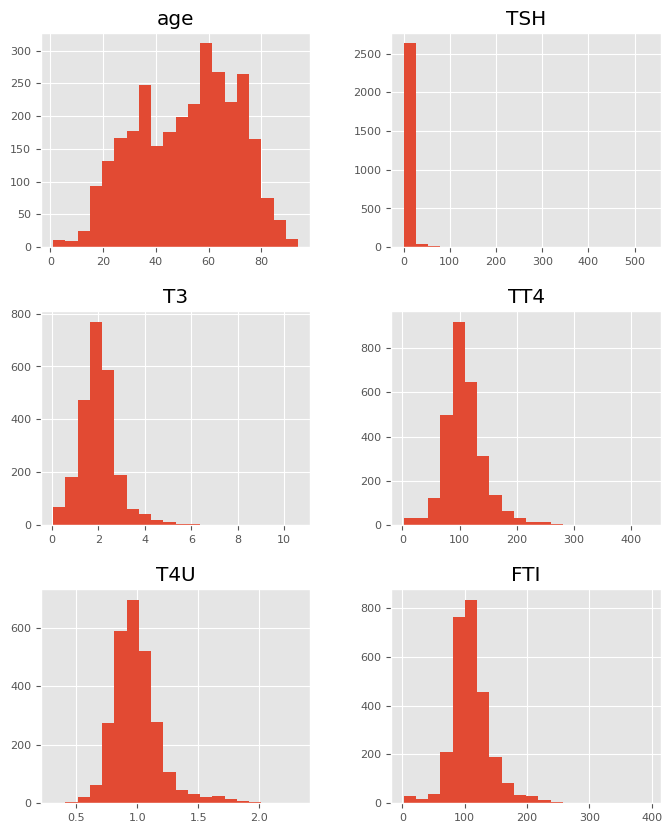

In [ ]:
# Check distribution to decide what kind of scaling to use
X_train[num_features].hist(figsize=(8, 10), bins=20, xlabelsize=8, ylabelsize=8);

`TSH` has skewed distribution,\
`age` - binomial,\
other variables - normal, exept for `TT4` and `TT4U` - normal with a slight skeweness.\
Let's use Robust Scaler that is robust to outliers.

In [ ]:
# Normalize numerical variables
robust_scaler = RobustScaler()

X_train[num_features] = robust_scaler.fit_transform(X_train[num_features])
X_test[num_features] = robust_scaler.transform(X_test[num_features])

In [ ]:
# Impute NAs in numerical variables of a train subset
X_train[num_features] = mf.ampute_data(
    X_train[num_features],
    perc=0.25,
    random_state=7)

kds = mf.ImputationKernel(
    X_train[num_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_train_num = kds.complete_data()


# Impute NAs in numerical variables of a test subset
X_test[num_features] = mf.ampute_data(
    X_test[num_features],
    perc=0.25,
    random_state=7)

kds = mf.ImputationKernel(
    X_test[num_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_test_num = kds.complete_data()

In [ ]:
# Exclude a target variable since we already encoded it into labels
cat_features = cat_features.drop('Class')

In [ ]:
# Encode categroical variables
enc = OrdinalEncoder()

X_train[cat_features] = enc.fit_transform(X_train[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])

In [ ]:
# Impute NAs in categorical variable
X_train[cat_features] = X_train[cat_features].astype('category')
X_train[cat_features] = mf.ampute_data(X_train[cat_features], perc=0.04, random_state=7)

kds = mf.ImputationKernel(
    X_train[cat_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_train_cat = kds.complete_data()


X_test[cat_features] = X_test[cat_features].astype('category')
X_test[cat_features] = mf.ampute_data(X_test[cat_features], perc=0.04, random_state=7)

kds = mf.ImputationKernel(
    X_test[cat_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_test_cat = kds.complete_data()

In [ ]:
# Concatenate columns with numerical and categorical features
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

# Modeling and Training

In [ ]:
# Determine the number of input features in the model
n_features = X_train.shape[1]
n_features

20

In [ ]:
# Define model
model = Sequential()
model.add(Dense(3, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Use early stopping to exit training if validation loss is not decreasing after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="Class_weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# Fit the model
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) // 16, epochs=150, batch_size=16,
                    verbose=0, callbacks=[checkpointer, earlystopping])


Epoch 1: val_loss improved from inf to 0.81247, saving model to Class_weights.hdf5

Epoch 2: val_loss improved from 0.81247 to 0.51888, saving model to Class_weights.hdf5

Epoch 3: val_loss improved from 0.51888 to 0.35928, saving model to Class_weights.hdf5

Epoch 4: val_loss improved from 0.35928 to 0.28865, saving model to Class_weights.hdf5

Epoch 5: val_loss improved from 0.28865 to 0.25629, saving model to Class_weights.hdf5

Epoch 6: val_loss improved from 0.25629 to 0.23932, saving model to Class_weights.hdf5

Epoch 7: val_loss improved from 0.23932 to 0.22876, saving model to Class_weights.hdf5

Epoch 8: val_loss improved from 0.22876 to 0.22177, saving model to Class_weights.hdf5

Epoch 9: val_loss improved from 0.22177 to 0.21661, saving model to Class_weights.hdf5

Epoch 10: val_loss improved from 0.21661 to 0.21182, saving model to Class_weights.hdf5

Epoch 11: val_loss improved from 0.21182 to 0.20785, saving model to Class_weights.hdf5

Epoch 12: val_loss improved from 

In [ ]:
# Save the model architecture to json file for further use
model_json = model.to_json()
with open("Class_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('Class_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('Class_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluation

In [ ]:
# Evaluate the model
acc = model.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f' % acc[1])
acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc[1])

Train Accuracy: 0.953
Test Accuracy: 0.957


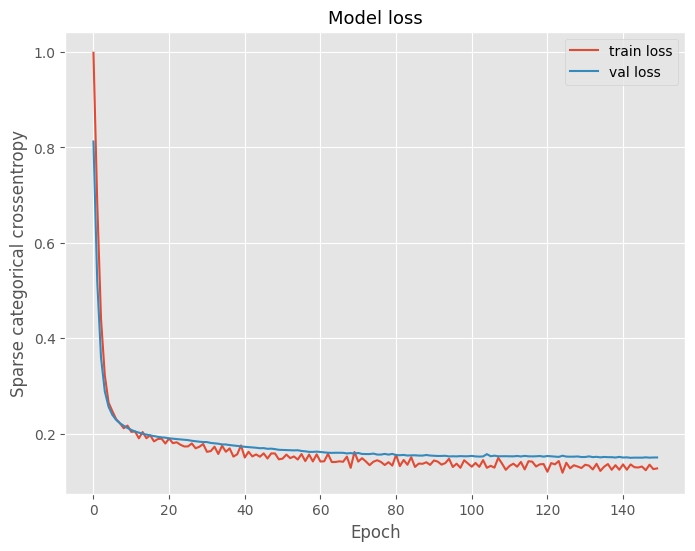

In [ ]:
# Plot loss during training
plt.title('Model loss', fontsize=13)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Sparse categorical crossentropy', fontsize=12)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

We can see that validation loss decreases to a point and begins increasing again being higher than train loss. It is an indication of overfitting.

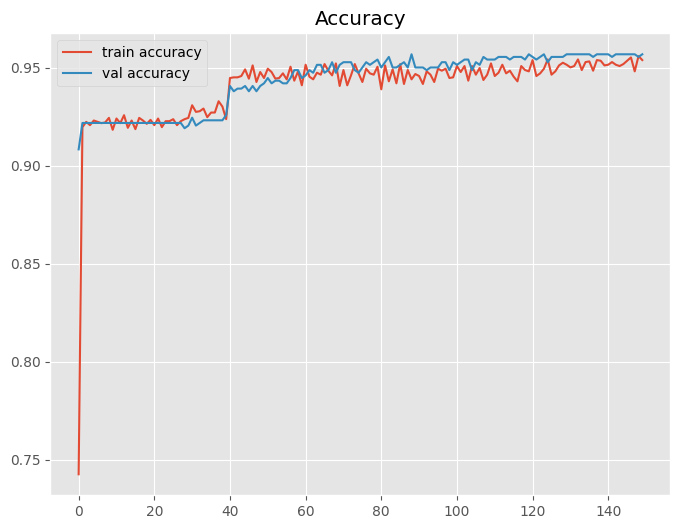

In [ ]:
# Plot accuracy during training
plt.subplot()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict probabilities for test set
yhat_probs=model.predict(X_test)
# Predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)

24/24 [==============================] - 0s 1ms/step


Our goal is to maximize recall since it is medical diagnosis and we should catch all positives. Keep in mind that `negative` is labelled as 1, `compensated_hypothyroid` as 0, `primary_hypothyroid` as 2.


===F2 scores:===
         F2
0  0.592784
1  0.977784
2  0.947368

===classification report:===
              precision    recall  f1-score   support

           0       0.61      0.59      0.60        39
           1       0.98      0.98      0.98       684
           2       0.95      0.95      0.95        19

    accuracy                           0.96       742
   macro avg       0.84      0.84      0.84       742
weighted avg       0.96      0.96      0.96       742


===confusion matrix===


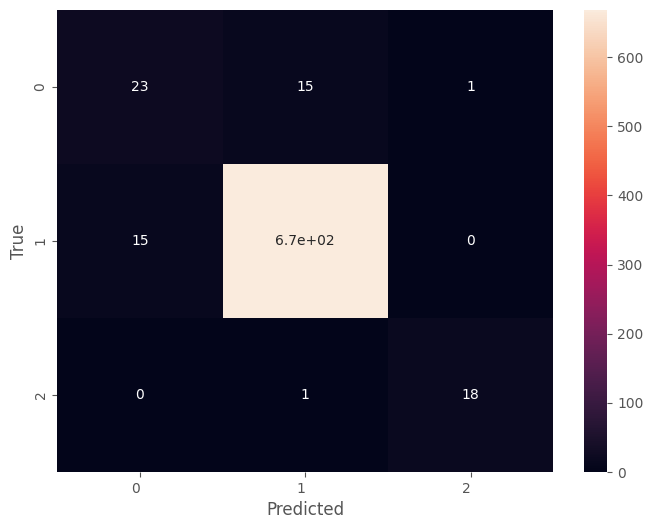

In [ ]:
# Create a report
report(y_test, yhat_classes)